In [1]:
import libsbml
from utils import functions
from utils import graph_functions
from utils import complete_tests
import random
import os
from copy import deepcopy
from collections import defaultdict
import pickle
import numpy as np

In [2]:
description = {
    'species': [],
    'reactions': [],
    'connections': [],
    'altered': ''
}

In [3]:
def alter_pathway(input_filename, output_filename, alterations):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(input_filename)
    model = document.getModel()

    for i in range(model.getNumParameters()):
        param = model.getParameter(i)
        if param.getId() == alterations:
            previous_value = param.getValue()
            param.setValue(previous_value * 100)
            modified_sbml = libsbml.writeSBML(document, output_filename)
            return 

In [4]:
def generate_test_set(filename):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    
    for i in range(model.getNumParameters()):
        base_dir = 'altered_pathways'
        alteration_dir = os.path.join(base_dir, 'reaction_' + str(i))
        file_dir = os.path.join(alteration_dir, 'reaction_' + str(i) + '100x.xml')
        os.makedirs(alteration_dir, exist_ok=True)
        
        param = model.getParameter(i)

        alter_pathway(filename, file_dir, param.getId())

In [5]:
generate_test_set('BIOMD0000000364.xml')

In [6]:
def convert_sbml_to_network(file_path):
    
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_path)
    if document.getNumErrors() > 0:
        print("Errors occurred while loading the SBML file.")
    model = document.getModel()
    
    num_reactions = model.getNumReactions()
    num_species = model.getNumSpecies()
    
    print('number reactions', model.getNumReactions())
    print('number species', model.getNumSpecies()) 
    
    for i in range(num_species):
        description['species'].append(model.getSpecies(i).getId())
    
    for i in range(num_reactions):
        description['reactions'].append([model.getReaction(i).getId(), 0, 1])
        num_reactants = model.getReaction(i).getNumReactants()
        num_products = model.getReaction(i).getNumProducts()
        formula = model.getReaction(i).getKineticLaw().getFormula()
        formula = formula.replace('(','')
        formula = formula.replace(' ', '')
        formula_splitted = formula.split('-')
        
        if len(formula_splitted) >= 2:
            description['reactions'].append([str(model.getReaction(i).getId() + 'revert'), 0, 1])
        
        for j in range(num_reactants):
            reactant = model.getReaction(i).getReactant(j).getSpecies()
            description['connections'].append([reactant, model.getReaction(i).getId()])
            if len(formula_splitted) == 2:
                description['connections'].append([str(model.getReaction(i).getId() + 'revert'), reactant])
            
        for k in range(num_products):
            product = model.getReaction(i).getProduct(k).getSpecies()
            description['connections'].append([model.getReaction(i).getId(), product])
            if len(formula_splitted) == 2:
                description['connections'].append([product, str(model.getReaction(i).getId() + 'revert')])

In [7]:
convert_sbml_to_network('BIOMD0000000364.xml')

number reactions 16
number species 14


In [8]:
for i in range(len(description['reactions'])):
    desc = deepcopy(description)
    desc['altered'] = desc['reactions'][i][0]
    base_dir = 'altered_pathways'
    alteration_dir = os.path.join(base_dir, 'reaction_' + str(i))
    description_path = os.path.join(alteration_dir, 'description')
    description_file = open(description_path, 'wb')
    pickle.dump(desc, description_file)
    description_file.close()
    

In [10]:
desc_path = 'altered_pathways/reaction_7/description'
desc_file = open(desc_path, 'rb')
temp = pickle.load(desc_file)
desc_file.close()
temp

{'species': ['E',
  'E_P_1',
  'P',
  'M',
  'M1',
  'E_M1',
  'E_M',
  'T',
  'E_P_2',
  'P2',
  'P21',
  'E_P21',
  'E_P2',
  'E_P1'],
 'reactions': [['r1', 0, 1],
  ['r1revert', 0, 1],
  ['r2', 0, 1],
  ['r3', 0, 1],
  ['r4', 0, 1],
  ['r4revert', 0, 1],
  ['r5', 0, 1],
  ['r5revert', 0, 1],
  ['r6', 0, 1],
  ['r7', 0, 1],
  ['r8', 0, 1],
  ['r8revert', 0, 1],
  ['r9', 0, 1],
  ['r10', 0, 1],
  ['r11', 0, 1],
  ['r11revert', 0, 1],
  ['r12', 0, 1],
  ['r12revert', 0, 1],
  ['r13', 0, 1],
  ['r14', 0, 1],
  ['r15', 0, 1],
  ['r16', 0, 1]],
 'connections': [['E', 'r1'],
  ['r1revert', 'E'],
  ['P', 'r1'],
  ['r1revert', 'P'],
  ['r1', 'E_P_1'],
  ['E_P_1', 'r1revert'],
  ['E_P_1', 'r2'],
  ['r2', 'E'],
  ['r2', 'M'],
  ['M', 'r3'],
  ['r3', 'M1'],
  ['E', 'r4'],
  ['r4revert', 'E'],
  ['M1', 'r4'],
  ['r4revert', 'M1'],
  ['r4', 'E_M1'],
  ['E_M1', 'r4revert'],
  ['E', 'r5'],
  ['r5revert', 'E'],
  ['M', 'r5'],
  ['r5revert', 'M'],
  ['r5', 'E_M'],
  ['E_M', 'r5revert'],
  ['E_M1', 'r

In [4]:
complete_results = defaultdict()
number_experiments = 0
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0
deltas_normal = []
deltas_uncertain = []

for directory in list(os.listdir('altered_pathways')):
    if directory == '.DS_Store':
        continue
    dir = os.path.join('altered_pathways', directory)
    files = os.listdir(dir)
    description_index = 0
    altered_file_index = 0

    for i in range(len(files)):
        if files[i] == 'description':
            description_index = i
        elif files[i] != 'description' and files[i] != 'results':
            altered_file_index = i
            
    res = complete_tests.complete_tests2(
            'BIOMD0000000364.xml',
            os.path.join(dir, files[altered_file_index]),
            os.path.join(dir, 'description'),
            []
        )

    if res['normal']['real'] is None or res['altered']['real'] is None: continue

    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=False, threshold=0, ignore_uncertain=False)

    total_species += all
    uncertain_species += uncertain

    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)

    total_count = 0
    correct_count = 0
    for specie in insights.keys():

        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue

        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1

        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1



    print(directory, ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)
    complete_results[directory] = correct_count / total_count


Converged at time 48019.0
Min and max abs differences:  0.0 9.871252149018517e-10
Specie:  E expected result:  decreased  normal final:  0.00010677242489530648  altered final:  4.672758832258753e-281
confidence interval:  [0.12380700181371715, 0.1275319073072889]
deltas coming from simulation:  [-0.00010677242489530648, 0]
Specie:  E_P_1 expected result:  decreased  normal final:  9.555879192279336e-157  altered final:  3.002140214651449e-281
confidence interval:  [0.28195218221380075, 0.29259668459595767]
deltas coming from simulation:  [-9.555879192279336e-157, 0]
Specie:  P expected result:  increased  normal final:  1.128885877682305e-152  altered final:  0.8104029752127935
confidence interval:  [0.035036576353888106, 0.04140854001761648]
deltas coming from simulation:  [0.8104029752127935, 0]
Specie:  M expected result:  increased  normal final:  8.88885541780495e-153  altered final:  0.031638628149512224
confidence interval:  [0.5165522719286327, 0.5277000128875818]
deltas coming

Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 812 and h = 4.07142e-09, the corrector convergence test failed repeatedly or with |h| = hmin.


Specie:  E expected result:  increased  normal final:  0.00010677242489530648  altered final:  0.00014951405775929014
confidence interval:  [0.12371870773169778, 0.12811611819480792]
deltas coming from simulation:  [4.274163286398366e-05, 0]
Specie:  E_P_1 expected result:  decreased  normal final:  9.555879192279336e-157  altered final:  2.5497267992193657e-298
confidence interval:  [0.8982086874384901, 0.9108209892740106]
deltas coming from simulation:  [-9.555879192279336e-157, 0]
Specie:  P expected result:  decreased  normal final:  1.128885877682305e-152  altered final:  2.133094522553497e-296
confidence interval:  [0.034926752899261095, 0.04243360822061024]
deltas coming from simulation:  [-1.128885877682305e-152, 0]
Specie:  M expected result:  increased  normal final:  8.88885541780495e-153  altered final:  1.3777557923006504e-07
confidence interval:  [0.7753236179087635, 0.7867250984641412]
deltas coming from simulation:  [1.3777557923006504e-07, 0]
Specie:  M1 expected resul

In [3]:
scores = []
for experiment in complete_results.keys():
    scores.append(complete_results[experiment])
print('Average score: ', np.average(np.array(scores)))

Average score:  0.5664335664335663


In [ ]:
scores

In [8]:
description['altered'] = 'React0'
description

{'species': ['BLL',
  'IL',
  'AL',
  'A',
  'BL',
  'B',
  'DLL',
  'D',
  'ILL',
  'DL',
  'I',
  'ALL',
  'L'],
 'reactions': [['React0', 0, 1],
  ['React0revert', 0, 1],
  ['React1', 0, 1],
  ['React1revert', 0, 1],
  ['React2', 0, 1],
  ['React2revert', 0, 1],
  ['React3', 0, 1],
  ['React3revert', 0, 1],
  ['React4', 0, 1],
  ['React4revert', 0, 1],
  ['React5', 0, 1],
  ['React5revert', 0, 1],
  ['React6', 0, 1],
  ['React6revert', 0, 1],
  ['React7', 0, 1],
  ['React7revert', 0, 1],
  ['React8', 0, 1],
  ['React8revert', 0, 1],
  ['React9', 0, 1],
  ['React9revert', 0, 1],
  ['React10', 0, 1],
  ['React10revert', 0, 1],
  ['React11', 0, 1],
  ['React11revert', 0, 1],
  ['React12', 0, 1],
  ['React12revert', 0, 1],
  ['React13', 0, 1],
  ['React13revert', 0, 1],
  ['React14', 0, 1],
  ['React14revert', 0, 1],
  ['React15', 0, 1],
  ['React15revert', 0, 1],
  ['React16', 0, 1],
  ['React16revert', 0, 1]],
 'connections': [['B', 'React0'],
  ['React0revert', 'B'],
  ['L', 'React0'

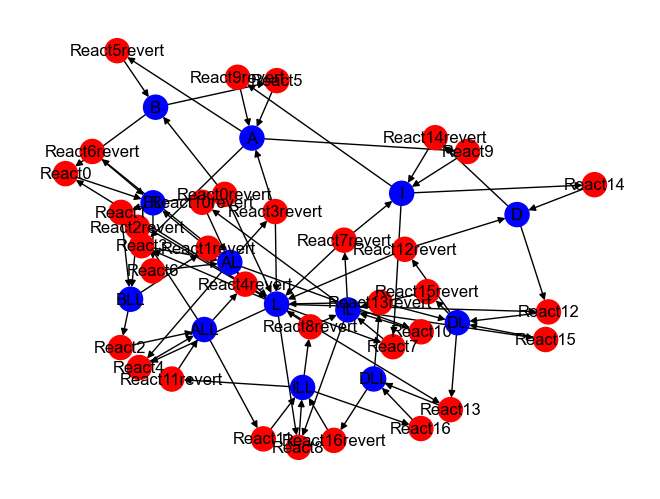

In [9]:
graph = functions.generate_graph(description)
functions.plot_graph(graph)

In [10]:
description_path = 'description_reaction1_altered'
description_file = open(description_path, 'wb')
pickle.dump(description, description_file)
description_file.close()

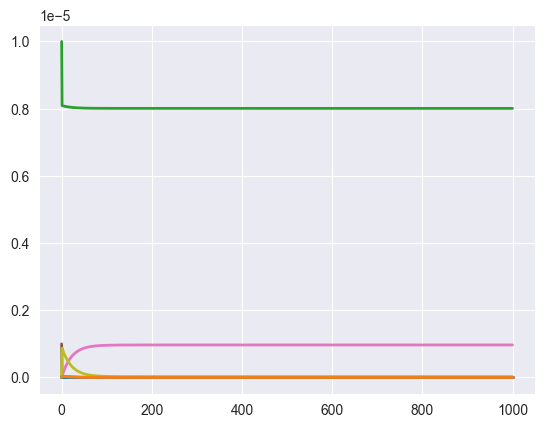

       time,       [BLL],        [IL],        [AL],         [A],        [BL],         [B],       [DLL],         [D],       [ILL],        [DL],         [I],       [ALL],         [L]
 [[       0,           0,           0,           0,           0,           0,       1e-06,           0,           0,           0,           0,           0,           0,       1e-05],
  [   1.001, 8.27425e-10, 5.73967e-09, 5.13544e-10,   1.803e-12,  1.0904e-08, 3.59462e-08, 3.97802e-08, 4.32293e-13, 8.70543e-07, 2.62272e-10,  9.4605e-12, 3.54722e-08, 8.08934e-06],
  [   2.002,  7.8975e-10, 5.48653e-09,  4.9038e-10, 1.72243e-12,  1.0412e-08, 3.43397e-08, 8.23008e-08, 8.95185e-13, 8.31768e-07, 5.42861e-10, 9.04739e-12, 3.38576e-08, 8.08563e-06],
  [   3.003, 7.54551e-10, 5.24426e-09, 4.68725e-10, 1.64707e-12,  9.9522e-09, 3.28373e-08, 1.22872e-07, 1.33763e-12, 7.94699e-07, 8.10819e-10, 8.65158e-12, 3.23486e-08, 8.08217e-06],
  [   4.004, 7.20967e-10, 5.01292e-09, 4.48047e-10, 1.57505e-12, 9.51314e-09, 3.14015e-

In [12]:
final_concentrations_normal = functions.plot_simulation_complete('BIOMD0000000002.xml')

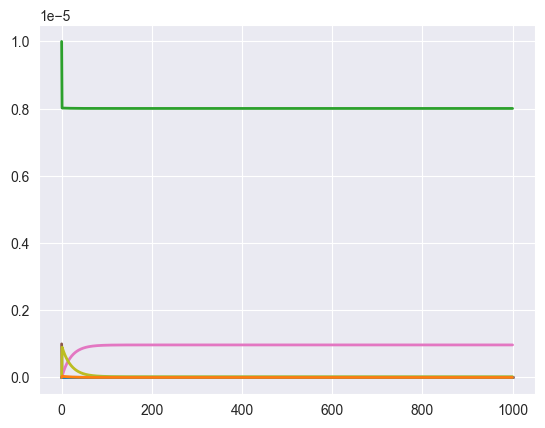

       time,       [BLL],        [IL],        [AL],         [A],        [BL],         [B],       [DLL],         [D],       [ILL],        [DL],         [I],       [ALL],         [L]
 [[       0,           0,           0,           0,           0,           0,       1e-06,           0,           0,           0,           0,           0,           0,       1e-05],
  [   1.001, 8.53635e-10, 5.99186e-09, 5.33551e-10, 3.66787e-13, 1.13475e-08, 3.77373e-10, 4.31094e-08, 4.76734e-13, 9.00892e-07, 2.86717e-10, 9.95038e-12, 3.65971e-08, 8.01894e-06],
  [   2.002,  8.1414e-10, 5.71507e-09, 5.08901e-10, 3.49847e-13, 1.08232e-08, 3.59963e-10, 8.70697e-08, 9.63014e-13, 8.59215e-07, 5.79135e-10,  9.4914e-12, 3.49038e-08, 8.01837e-06],
  [   3.003,  7.7652e-10, 5.45138e-09, 4.85418e-10, 3.33709e-13, 1.03238e-08, 3.43377e-10, 1.28944e-07, 1.42635e-12, 8.19516e-07, 8.57717e-10, 9.05408e-12,  3.3291e-08, 8.01783e-06],
  [   4.004, 7.40688e-10, 5.20019e-09, 4.63049e-10, 3.18335e-13, 9.84807e-09, 3.27574e-

In [13]:
final_concentrations_altered = functions.plot_simulation_complete('BIOMD0000000002_reaction1_100x.xml')

In [14]:
species = description['species']
species

['BLL', 'IL', 'AL', 'A', 'BL', 'B', 'DLL', 'D', 'ILL', 'DL', 'I', 'ALL', 'L']

In [15]:
final_normal = final_concentrations_normal[0][-1]
final_altered = final_concentrations_altered[0][-1]

In [16]:
final_normal

[1.00000000e+03 2.19388783e-11 1.54698487e-10 1.37528184e-11
 4.87619948e-14 2.91968329e-10 9.72150307e-10 9.67917963e-07
 1.07308290e-11 2.32300311e-08 6.44563796e-09 2.57544100e-13
 9.40625486e-10 8.00887231e-06]

In [17]:
temp = final_concentrations_normal[1]
temp

[0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 1.e-05]

In [18]:
import math
expected_results = {}
for i in range(len(species)):
    delta1 = 0
    delta2 = 0
    print(species[i])
    if final_normal[i + 1] != 0:
        if temp[i] != 0:
            initial_concentration = temp[i]
            delta1 = math.fabs((final_altered[i + 1] - final_normal[i + 1]) / initial_concentration)
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta1 * delta2
        else:
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta2 / 100
            
        relative_delta = (final_altered[i + 1] - final_normal[i + 1]) / final_normal[i + 1]
        
    else: 
        relative_delta = 0
        
    if paired_delta >= 0.001 and final_altered[i + 1] < final_normal[i + 1]:
        expected_results[species[i]] = 'decreased'
    elif paired_delta >= 0.001 and final_altered[i + 1] > final_normal[i + 1]:
        expected_results[species[i]] = 'increased'
    else:
        expected_results[species[i]] = 'unchanged'
    
    print('final normal: ', final_normal[i + 1], 'final altered: ', final_altered[i + 1], 'delta: ', final_altered[i + 1] - final_normal[i + 1], 'relative delta ', relative_delta, 'initial concentration: ', temp[i], 'delta1', delta1, 'delta2', delta2)

BLL
final normal:  2.1938878276332772e-11 final altered:  2.1962330534035098e-11 delta:  2.345225770232575e-14 relative delta  0.0010689816228036408 initial concentration:  0.0 delta1 0 delta2 0.0010689816228035554
IL
final normal:  1.5469848668850356e-10 final altered:  1.5488334632379436e-10 delta:  1.848596352908016e-13 relative delta  0.0011949673151168548 initial concentration:  0.0 delta1 0 delta2 0.0011949673151168128
AL
final normal:  1.3752818392015876e-11 final altered:  1.3747589227238809e-11 delta:  -5.229164777066961e-15 relative delta  -0.0003802249566607179 initial concentration:  0.0 delta1 0 delta2 0.0003802249566606797
A
final normal:  4.876199475021198e-14 final altered:  9.454163986341904e-15 delta:  -3.9307830763870074e-14 relative delta  -0.8061161354294103 initial concentration:  0.0 delta1 0 delta2 0.8061161354294103
BL
final normal:  2.9196832933288264e-10 final altered:  2.923740386724699e-10 delta:  4.0570933958723873e-13 relative delta  0.0013895662605401158

In [19]:
expected_results

{'BLL': 'unchanged',
 'IL': 'unchanged',
 'AL': 'unchanged',
 'A': 'decreased',
 'BL': 'unchanged',
 'B': 'unchanged',
 'DLL': 'unchanged',
 'D': 'unchanged',
 'ILL': 'unchanged',
 'DL': 'unchanged',
 'I': 'unchanged',
 'ALL': 'unchanged',
 'L': 'unchanged'}

In [17]:
description['reactions'][0][1] = 0.2

In [18]:
for i in range(len(description['reactions'])):
    description['reactions'][i][2] = random.uniform(0, 1)

In [19]:
graph = graph_functions.generate_graph(description)

In [20]:
species_propagation = []
for i in range(100):
    print("ITERATION ", i)
    species_propagation.append(graph_functions.update_graph(graph, 1, i + 1))

ITERATION  0
---values before iteration---
{'M': 0.5, 'MpY': 0.5, 'MpT': 0.5, 'Mpp': 0.5, 'MAPKK': 0.5, 'MKP': 0.5, 'MpY_MAPKK': 0.5, 'MpT_MAPKK': 0.5, 'M_MAPKK_Y': 0.5, 'M_MAPKK_T': 0.5, 'Mpp_MKP_Y': 0.5, 'Mpp_MKP_T': 0.5, 'MpY_MKP_Y': 0.5, 'MpY_MKP_T': 0.5, 'MpT_MKP_Y': 0.5, 'MpT_MKP_T': 0.5, 'M_MKP_T': 0.5, 'M_MKP_Y': 0.5}
Firing reaction  reaction_0000001
reactant:  M  delta:  0.0
reactant:  MAPKK  delta:  0.0
{'type': 'reaction', 'strength': 0.2, 'weight': 0.31049363849558864}
new reaction strength:  0.0  reaction weight:  0.31049363849558864  reaction strength  0.2
reactant:  M  new value:  0.31002551887238755  delta:  -0.18997448112761245
reactant:  MAPKK  new value:  0.31002551887238755  delta:  -0.18997448112761245
product:  M_MAPKK_Y new value:  0.6899744811276125
Firing reaction  reaction_0000001revert
reactant:  M_MAPKK_Y  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.678764660401966}
new reaction strength:  0.0  reaction weight:  0.678764660401966  reaction s

In [21]:
species_propagation

[{'M': 0.31002551887238755,
  'MpY': 0.5,
  'MpT': 0.5,
  'Mpp': 0.5,
  'MAPKK': 0.31002551887238755,
  'MKP': 0.5,
  'MpY_MAPKK': 0.5,
  'MpT_MAPKK': 0.5,
  'M_MAPKK_Y': 0.6899744811276125,
  'M_MAPKK_T': 0.5,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.5,
  'M_MKP_Y': 0.5},
 {'M': 0.6708783557279607,
  'MpY': 0.9422795106044548,
  'MpT': 0.8670982768741314,
  'Mpp': 0.5,
  'MAPKK': 0.5913580924001746,
  'MKP': 0.9290585038041786,
  'MpY_MAPKK': 0.08410755778349127,
  'MpT_MAPKK': 0.13290172312586868,
  'M_MAPKK_Y': 0.09475501814094794,
  'M_MAPKK_T': 0.025746483254046715,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.06570426290880449,
  'M_MKP_Y': 0.0761787294828381},
 {'M': 0.04762354052406159,
  'MpY': 0.44484555728100167,
  'MpT': 0.33842444463130605,
  'Mpp': 0.027778923927269716,
  'MAPKK': 0.03456896

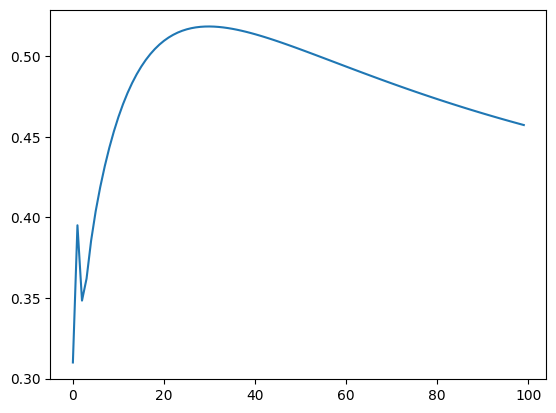

In [74]:
import matplotlib.pyplot as plt
concentrations = [conc['M'] for conc in species_propagation]
concentrations
plt.plot(concentrations[0:500])

In [75]:
final_propagation = species_propagation[-1]
for s in final_propagation.keys():
    print(s, 'propagation results: ', final_propagation[s], 'simulation results: ', expected_results[s])

M propagation results:  0.4573673063139326 simulation results:  increased
MpY propagation results:  0.5859506999350107 simulation results:  increased
MpT propagation results:  0.42683903449371147 simulation results:  increased
Mpp propagation results:  0.38758917256795355 simulation results:  unchanged
MAPKK propagation results:  0.4282587576580072 simulation results:  decreased
MKP propagation results:  0.5468037734808247 simulation results:  increased
MpY_MAPKK propagation results:  0.5034654849769683 simulation results:  unchanged
MpT_MAPKK propagation results:  0.4660739809818277 simulation results:  unchanged
M_MAPKK_Y propagation results:  0.5647061946329963 simulation results:  increased
M_MAPKK_T propagation results:  0.47072859983635107 simulation results:  unchanged
Mpp_MKP_Y propagation results:  0.4835596299636847 simulation results:  unchanged
Mpp_MKP_T propagation results:  0.4836623648528669 simulation results:  unchanged
MpY_MKP_Y propagation results:  0.534006843731000

In [2]:
res = complete_tests.complete_tests2(
            'BIOMD0000000002.xml',
            'BIOMD0000000002_reaction1_100x.xml',
            'description_reaction1_altered',
            []
        )

In [3]:
insights = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=True, threshold=0)

Specie:  BLL expected result:  increased
confidence interval:  [0.46393818392335173, 0.4651895858658508]
Specie:  IL expected result:  increased
confidence interval:  [0.4918785340001528, 0.4925704565595165]
Specie:  AL expected result:  decreased
confidence interval:  [0.5065285893511426, 0.5072758157003454]
Specie:  A expected result:  decreased
confidence interval:  [0.5349639173182256, 0.5364302739174643]
Specie:  BL expected result:  increased
confidence interval:  [0.559065924525973, 0.5603631835678557]
Specie:  B expected result:  decreased
confidence interval:  [0.46810435344133416, 0.46973740729840596]
Specie:  DLL expected result:  increased
confidence interval:  [0.4434473091382436, 0.4449685666287827]
Specie:  D expected result:  increased
confidence interval:  [0.5666964121006711, 0.5689451845387273]
Specie:  ILL expected result:  increased
confidence interval:  [0.44653244694503513, 0.44776890984977236]
Specie:  DL expected result:  increased
confidence interval:  [0.4880

In [4]:
total_count = 0
correct_count = 0
for specie in insights.keys():
    total_count += 1
    if insights[specie][0] == insights[specie][1]:
        correct_count += 1
print('total experiments: ', total_count, 'correct experiments: ', correct_count, 'ratio: ', correct_count/total_count)

total experiments:  13 correct experiments:  5 ratio:  0.38461538461538464


In [31]:
total_count = 0
correct_count = 0
for specie in insights[2].keys():
    if expected_results[specie] != 'unchanged':
        total_count += 1
    if type(specie) != type(''):
        continue
    print('specie: ', specie)
    scores = np.array(insights[2][specie][-1])
    mean = np.mean(scores)
    std = np.std(scores)
    std_error = std / np.sqrt(len(scores))
    margin = 2 * std_error
    lower = mean - margin
    higher = mean + margin
    print(' lower: ', lower, ' higher: ', higher)
    if lower > 0.5: 
        print('increase, expected: ', expected_results[specie])
        if expected_results[specie] == 'increased':
            correct_count += 1
        
    else: 
        print('decrease, expected: ', expected_results[specie])
        if expected_results[specie] == 'decreased':
            correct_count += 1
print('ratio correct: ', correct_count / total_count, 'correct: ', correct_count, 'total: ', total_count)

specie:  M
 lower:  0.4637417533839022  higher:  0.4673349186799267
decrease, expected:  increased
specie:  MpY
 lower:  0.5991303309472806  higher:  0.6023748512798377
increase, expected:  increased
specie:  MpT
 lower:  0.4718955701272027  higher:  0.4759069512085346
decrease, expected:  increased
specie:  Mpp
 lower:  0.3756636941126044  higher:  0.3789976416682042
decrease, expected:  decreased
specie:  MAPKK
 lower:  0.3602388673451398  higher:  0.36140146766758047
decrease, expected:  decreased
specie:  MKP
 lower:  0.5607346855559303  higher:  0.5631176832807838
increase, expected:  increased
specie:  MpY_MAPKK
 lower:  0.489276800582603  higher:  0.49027261550261664
decrease, expected:  decreased
specie:  MpT_MAPKK
 lower:  0.4604340713427221  higher:  0.4614110647921208
decrease, expected:  decreased
specie:  M_MAPKK_Y
 lower:  0.552772153190489  higher:  0.5540794675295615
increase, expected:  increased
specie:  M_MAPKK_T
 lower:  0.455282023422336  higher:  0.456438765868962

<Axes: ylabel='Count'>

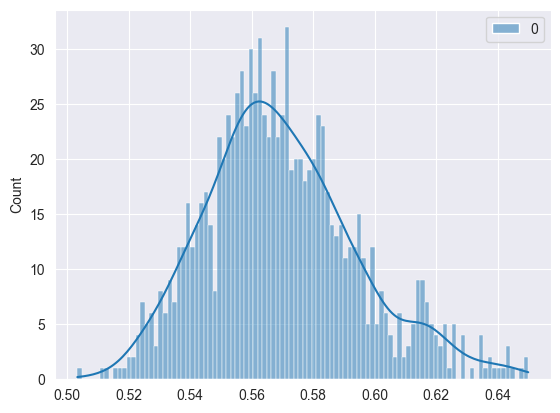

In [30]:
import pandas as pd 
import seaborn as sns
scores = np.array(insights[2]['MpY_MKP_T'][-1])
df = pd.DataFrame(scores)
sns.histplot(df, kde=True, bins=100)